In [1]:
# ============================================================
# STEP 1 — AUTOMATED PROJECT SETUP FOR DAYHOFF MARL GENOMICS
# ============================================================

from google.colab import drive
import os, sys

# ---------------------------
# 1. Mount Google Drive
# ---------------------------
drive.mount('/content/drive')

# ---------------------------
# 2. Create project structure
# ---------------------------
PROJECT_ROOT = "/content/drive/MyDrive/dayhoff_marl_genomics"

subdirs = [
    "data_raw",        # raw datasets (RNA-Seq etc.)
    "data_processed",  # cleaned, normalized data
    "src",             # all Python modules (agents, envs, RL trainer)
    "results",         # logs, metrics, training curves
    "reports",         # figures, notes for your final PDF
]

os.makedirs(PROJECT_ROOT, exist_ok=True)

for sd in subdirs:
    os.makedirs(os.path.join(PROJECT_ROOT, sd), exist_ok=True)

# ---------------------------
# 3. Add to Python path
# ---------------------------
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)

# ---------------------------
# 4. Confirmation Output
# ---------------------------
print("📁 Project created at:", PROJECT_ROOT)
print("📂 Contents:", os.listdir(PROJECT_ROOT))
print("🔧 Python paths updated.")


Mounted at /content/drive
📁 Project created at: /content/drive/MyDrive/dayhoff_marl_genomics
📂 Contents: ['data_raw', 'data_processed', 'src', 'results', 'reports']
🔧 Python paths updated.


In [3]:
# ============================================================
# STEP 2 — Download & Preprocess Gene Expression Dataset (SKLEARN)
# ============================================================

from google.colab import drive
import os, sys
import pandas as pd
import numpy as np

# Mount drive
drive.mount('/content/drive')

PROJECT_ROOT = "/content/drive/MyDrive/dayhoff_marl_genomics"
DATA_RAW = os.path.join(PROJECT_ROOT, "data_raw")
DATA_PROCESSED = os.path.join(PROJECT_ROOT, "data_processed")
SRC_PATH = os.path.join(PROJECT_ROOT, "src")

if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)

print("📁 Using project at:", PROJECT_ROOT)

# ============================================================
# 1. Load Breast Cancer Gene Expression Dataset
# ============================================================

from sklearn.datasets import load_breast_cancer
bc = load_breast_cancer()

X_raw = pd.DataFrame(bc.data, columns=bc.feature_names)
y_raw = pd.Series(bc.target, name="label")   # 0 = malignant, 1 = benign

print("\n✅ Loaded gene-expression dataset from sklearn")
print("X shape:", X_raw.shape)
print("y distribution:")
print(y_raw.value_counts())

# ============================================================
# 2. Save RAW data
# ============================================================

raw_feat_path = os.path.join(DATA_RAW, "gene_expression_raw_features.parquet")
raw_label_path = os.path.join(DATA_RAW, "gene_expression_raw_labels.parquet")

X_raw.to_parquet(raw_feat_path, index=False)
y_raw.to_frame().to_parquet(raw_label_path, index=False)

print("\n💾 Saved raw features →", raw_feat_path)
print("💾 Saved raw labels   →", raw_label_path)

# ============================================================
# 3. Preprocessing: Standardize features
# ============================================================

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw.astype(float))

X_scaled_df = pd.DataFrame(X_scaled, columns=X_raw.columns)

proc_feat_path = os.path.join(DATA_PROCESSED, "gene_expression_scaled_features.parquet")
proc_label_path = os.path.join(DATA_PROCESSED, "gene_expression_labels.parquet")

X_scaled_df.to_parquet(proc_feat_path, index=False)
y_raw.to_frame().to_parquet(proc_label_path, index=False)

print("\n💾 Saved scaled features →", proc_feat_path)
print("💾 Saved labels         →", proc_label_path)

# ============================================================
# 4. Write data_prep.py module
# ============================================================

data_prep_code = r'''
import os
import pandas as pd

def get_project_root():
    return "/content/drive/MyDrive/dayhoff_marl_genomics"

def load_raw_gene_expression():
    root = get_project_root()
    X = pd.read_parquet(os.path.join(root, "data_raw", "gene_expression_raw_features.parquet"))
    y = pd.read_parquet(os.path.join(root, "data_raw", "gene_expression_raw_labels.parquet"))["label"]
    return X, y

def load_processed_gene_expression():
    root = get_project_root()
    X = pd.read_parquet(os.path.join(root, "data_processed", "gene_expression_scaled_features.parquet"))
    y = pd.read_parquet(os.path.join(root, "data_processed", "gene_expression_labels.parquet"))["label"]
    return X, y
'''

with open(os.path.join(SRC_PATH, "data_prep.py"), "w") as f:
    f.write(data_prep_code)

print("\n🧩 data_prep.py created.")

# ============================================================
# 5. Test loader
# ============================================================

import importlib
data_prep = importlib.import_module("data_prep")

X_test, y_test = data_prep.load_processed_gene_expression()

print("\n✅ Loader test passed")
print("Processed X shape:", X_test.shape)
print("Processed y shape:", y_test.shape)
print("Label counts:")
print(y_test.value_counts())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Using project at: /content/drive/MyDrive/dayhoff_marl_genomics

✅ Loaded gene-expression dataset from sklearn
X shape: (569, 30)
y distribution:
label
1    357
0    212
Name: count, dtype: int64

💾 Saved raw features → /content/drive/MyDrive/dayhoff_marl_genomics/data_raw/gene_expression_raw_features.parquet
💾 Saved raw labels   → /content/drive/MyDrive/dayhoff_marl_genomics/data_raw/gene_expression_raw_labels.parquet

💾 Saved scaled features → /content/drive/MyDrive/dayhoff_marl_genomics/data_processed/gene_expression_scaled_features.parquet
💾 Saved labels         → /content/drive/MyDrive/dayhoff_marl_genomics/data_processed/gene_expression_labels.parquet

🧩 data_prep.py created.

✅ Loader test passed
Processed X shape: (569, 30)
Processed y shape: (569,)
Label counts:
label
1    357
0    212
Name: count, dtype: int64


In [4]:
# ============================================================
# STEP 3 — Define Dayhoff Multi-Agent Environment for Genomics
# ============================================================

from google.colab import drive
drive.mount('/content/drive')

import os, sys
import importlib

# ---------------------------
# 1. Paths & imports
# ---------------------------
PROJECT_ROOT = "/content/drive/MyDrive/dayhoff_marl_genomics"
SRC_PATH = os.path.join(PROJECT_ROOT, "src")

if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)

# Import data loaders from previous step
data_prep = importlib.import_module("data_prep")

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score


# ---------------------------
# 2. Write env_dayhoff_marl.py
# ---------------------------
env_code = r'''
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score


@dataclass
class ClusteringAction:
    """
    Action taken by the Clustering Agent.
    - n_clusters: number of clusters for KMeans
    - pca_components: dimension to reduce to before clustering (None = no PCA)
    """
    n_clusters: int
    pca_components: int


@dataclass
class AnomalyAction:
    """
    Action taken by the Anomaly Agent.
    - contamination: expected proportion of anomalies for IsolationForest
    """
    contamination: float


class DayhoffMarlEnv:
    """
    Multi-agent environment for Dayhoff-style genomic pattern discovery.

    Agents:
      - Clustering Agent: chooses (n_clusters, pca_dim)
      - Anomaly Agent: chooses contamination level for anomaly detection

    Environment:
      - Uses preprocessed gene expression features X (patients x genes)
      - Uses labels y (e.g., 0 = malignant, 1 = benign)
      - Each episode samples a subset of patients to simulate different cohorts.
      - Applies PCA (optional), KMeans clustering, and IsolationForest.

    Reward (shared by both agents):
      - Higher when:
          * Cluster structure is strong (high silhouette score)
          * Anomalies align with diseased cases (more malignant samples flagged)
      - Lower when:
          * Clusters are noisy (low or negative silhouette)
          * Anomalies are random/not aligned with labels
    """

    def __init__(
        self,
        X: np.ndarray,
        y: np.ndarray,
        clustering_actions: List[ClusteringAction],
        anomaly_actions: List[AnomalyAction],
        episode_sample_size: int = 150,
        random_state: int = 42,
    ):
        self.X_full = X
        self.y_full = y
        self.clustering_actions = clustering_actions
        self.anomaly_actions = anomaly_actions
        self.episode_sample_size = min(episode_sample_size, X.shape[0])
        self.rng = np.random.default_rng(random_state)

        self.n_samples = X.shape[0]
        self.current_indices = None  # indices of current episode subset
        self.episode = 0

    def reset(self) -> Dict[str, Any]:
        """
        Start a new episode:
          - Sample a subset of patients.
          - Return a simple "state" describing subset stats.

        For now, we keep state minimal; RL agents mainly learn from rewards.
        """
        self.episode += 1
        self.current_indices = self.rng.choice(
            self.n_samples,
            size=self.episode_sample_size,
            replace=False
        )

        X_sub = self.X_full[self.current_indices]
        y_sub = self.y_full[self.current_indices]

        # Basic state summary (could be used later if you want context-based policies)
        state = {
            "episode": self.episode,
            "n_samples": X_sub.shape[0],
            "label_mean": float(y_sub.mean()),
        }

        return state

    def step(
        self,
        clustering_action_idx: int,
        anomaly_action_idx: int,
    ) -> Tuple[Dict[str, Any], float, bool, Dict[str, Any]]:
        """
        Execute a joint action from:
          - Clustering agent (by index into clustering_actions list)
          - Anomaly agent (by index into anomaly_actions list)

        Returns:
          - next_state: dict with episode info
          - reward: shared scalar reward for all agents
          - done: bool (always True per episode)
          - info: dict with detailed metrics for logging/analysis
        """

        if self.current_indices is None:
            raise RuntimeError("Environment not reset. Call reset() before step().")

        if not (0 <= clustering_action_idx < len(self.clustering_actions)):
            raise ValueError("Invalid clustering_action_idx")

        if not (0 <= anomaly_action_idx < len(self.anomaly_actions)):
            raise ValueError("Invalid anomaly_action_idx")

        X_sub = self.X_full[self.current_indices]
        y_sub = self.y_full[self.current_indices]

        c_action = self.clustering_actions[clustering_action_idx]
        a_action = self.anomaly_actions[anomaly_action_idx]

        # 1) PCA (optional)
        if c_action.pca_components is not None and c_action.pca_components > 0:
            pca = PCA(n_components=c_action.pca_components, random_state=0)
            X_used = pca.fit_transform(X_sub)
            pca_dim = c_action.pca_components
        else:
            X_used = X_sub
            pca_dim = X_sub.shape[1]

        # 2) KMeans clustering
        try:
            km = KMeans(
                n_clusters=c_action.n_clusters,
                n_init=10,
                random_state=0,
            )
            cluster_labels = km.fit_predict(X_used)

            # Silhouette score can fail if all points fall into 1 cluster or near
            sil = silhouette_score(X_used, cluster_labels)
        except Exception:
            cluster_labels = np.zeros(X_used.shape[0], dtype=int)
            sil = -1.0  # bad clustering

        # 3) Anomaly detection (IsolationForest)
        try:
            iso = IsolationForest(
                n_estimators=100,
                contamination=a_action.contamination,
                random_state=0,
            )
            anomaly_scores = iso.fit_predict(X_used)  # -1 = outlier, 1 = normal
        except Exception:
            anomaly_scores = np.ones(X_used.shape[0], dtype=int)

        # Compute anomaly metrics:
        #   fraction of malignant vs benign flagged as anomalies
        #   A good pattern: more malignant flagged than benign (biologically plausible)
        malignant_mask = (y_sub == 0)  # depending on encoding: 0 = malignant, 1 = benign
        benign_mask = (y_sub == 1)

        anomalies = (anomaly_scores == -1)

        # Avoid division by zero
        malign_frac = (
            anomalies[malignant_mask].mean() if malignant_mask.any() else 0.0
        )
        benign_frac = (
            anomalies[benign_mask].mean() if benign_mask.any() else 0.0
        )

        # Alignment score: how much more often malignant are flagged vs benign
        anomaly_alignment = malign_frac - benign_frac

        # 4) Reward design
        #    Combine:
        #      - cluster_quality = silhouette_score (range roughly -1 to 1)
        #      - anomaly_alignment (range roughly -1 to 1)
        #    With mild penalty for too many clusters (complexity)
        cluster_penalty = 0.05 * (c_action.n_clusters - 2)

        reward = (
            1.0 * sil +
            0.5 * anomaly_alignment -
            cluster_penalty
        )

        info = {
            "episode": self.episode,
            "clustering_action": c_action,
            "anomaly_action": a_action,
            "silhouette": float(sil),
            "anomaly_alignment": float(anomaly_alignment),
            "malignant_anomaly_frac": float(malign_frac),
            "benign_anomaly_frac": float(benign_frac),
            "cluster_penalty": float(cluster_penalty),
            "reward": float(reward),
            "pca_dim": int(pca_dim),
            "n_clusters": int(c_action.n_clusters),
            "contamination": float(a_action.contamination),
        }

        # For now, each episode is one step → done=True
        next_state = {
            "episode": self.episode,
            "n_samples": X_sub.shape[0],
            "label_mean": float(y_sub.mean()),
        }
        done = True

        return next_state, reward, done, info
'''

env_path = os.path.join(SRC_PATH, "env_dayhoff_marl.py")
with open(env_path, "w") as f:
    f.write(env_code)

print("🧩 env_dayhoff_marl.py written to:", env_path)

# ---------------------------
# 3. Test the environment
# ---------------------------
import importlib
env_module = importlib.import_module("env_dayhoff_marl")
DayhoffMarlEnv = env_module.DayhoffMarlEnv
ClusteringAction = env_module.ClusteringAction
AnomalyAction = env_module.AnomalyAction

# Load processed gene-expression data
X_df, y_series = data_prep.load_processed_gene_expression()
X = X_df.values.astype(float)
y = y_series.values.astype(int)

print("\n✅ Loaded processed data for env:")
print("X shape:", X.shape, "| y shape:", y.shape)

# Define a small discrete action space for both agents
clustering_actions = [
    ClusteringAction(n_clusters=2, pca_components=2),
    ClusteringAction(n_clusters=3, pca_components=2),
    ClusteringAction(n_clusters=4, pca_components=5),
    ClusteringAction(n_clusters=5, pca_components=5),
]

anomaly_actions = [
    AnomalyAction(contamination=0.01),
    AnomalyAction(contamination=0.05),
    AnomalyAction(contamination=0.10),
]

# Create environment instance
env = DayhoffMarlEnv(
    X=X,
    y=y,
    clustering_actions=clustering_actions,
    anomaly_actions=anomaly_actions,
    episode_sample_size=150,
    random_state=123,
)

print("\n🌱 Environment initialized.")

# Run a single test episode
state = env.reset()
print("\nInitial state:", state)

next_state, reward, done, info = env.step(
    clustering_action_idx=1,   # e.g., 3 clusters, 2D PCA
    anomaly_action_idx=1,      # e.g., contamination = 0.05
)

print("\n🎯 Step result:")
print("Next state:", next_state)
print("Reward:", reward)
print("Done:", done)
print("Info metrics:")
for k, v in info.items():
    print(f"  {k}: {v}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🧩 env_dayhoff_marl.py written to: /content/drive/MyDrive/dayhoff_marl_genomics/src/env_dayhoff_marl.py

✅ Loaded processed data for env:
X shape: (569, 30) | y shape: (569,)

🌱 Environment initialized.

Initial state: {'episode': 1, 'n_samples': 150, 'label_mean': 0.6}

🎯 Step result:
Next state: {'episode': 1, 'n_samples': 150, 'label_mean': 0.6}
Reward: 0.4368244718707887
Done: True
Info metrics:
  episode: 1
  clustering_action: ClusteringAction(n_clusters=3, pca_components=2)
  anomaly_action: AnomalyAction(contamination=0.05)
  silhouette: 0.44793558298189984
  anomaly_alignment: 0.07777777777777778
  malignant_anomaly_frac: 0.1
  benign_anomaly_frac: 0.022222222222222223
  cluster_penalty: 0.05
  reward: 0.4368244718707887
  pca_dim: 2
  n_clusters: 3
  contamination: 0.05


In [5]:
# ============================================================
# STEP 4 — Multi-Agent RL (Q-learning + UCB) + Training Script
# ============================================================

from google.colab import drive
drive.mount('/content/drive')

import os, sys, importlib

PROJECT_ROOT = "/content/drive/MyDrive/dayhoff_marl_genomics"
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
RESULTS_PATH = os.path.join(PROJECT_ROOT, "results")

os.makedirs(RESULTS_PATH, exist_ok=True)

if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)

# Confirm existing modules
data_prep = importlib.import_module("data_prep")
env_mod = importlib.import_module("env_dayhoff_marl")
DayhoffMarlEnv = env_mod.DayhoffMarlEnv
ClusteringAction = env_mod.ClusteringAction
AnomalyAction = env_mod.AnomalyAction

print("✅ Found data_prep and env_dayhoff_marl")


# ============================================================
# 1) Create rl_agents.py  (Q-learning + UCB bandit)
# ============================================================

rl_agents_code = r'''
import numpy as np


class QLearningClusteringAgent:
    """
    Tabular Q-learning agent for the Clustering Agent.
    We treat the environment as bandit-like (single state).
    """

    def __init__(
        self,
        n_actions: int,
        alpha: float = 0.3,
        gamma: float = 0.0,  # bandit style → no bootstrapping
        epsilon_start: float = 0.8,
        epsilon_end: float = 0.1,
        epsilon_decay_steps: int = 100,
        random_seed: int = 42,
    ):
        self.n_states = 1        # single abstract state
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma

        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_steps = max(1, epsilon_decay_steps)
        self.step_count = 0

        self.rng = np.random.default_rng(random_seed)
        self.Q = np.zeros((self.n_states, self.n_actions), dtype=float)

    def _current_epsilon(self) -> float:
        frac = min(1.0, self.step_count / self.epsilon_decay_steps)
        return float(self.epsilon_start + frac * (self.epsilon_end - self.epsilon_start))

    def select_action(self, state: int = 0) -> int:
        epsilon = self._current_epsilon()
        self.step_count += 1

        if self.rng.random() < epsilon:
            # Explore
            return int(self.rng.integers(0, self.n_actions))
        else:
            # Exploit
            q_values = self.Q[state]
            max_q = np.max(q_values)
            best_actions = np.flatnonzero(q_values == max_q)
            return int(self.rng.choice(best_actions))

    def update(self, action: int, reward: float, state: int = 0, next_state: int = 0, done: bool = True):
        q_sa = self.Q[state, action]
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.Q[next_state])

        self.Q[state, action] = q_sa + self.alpha * (target - q_sa)


class UCBAnomalyAgent:
    """
    UCB1 (Upper Confidence Bound) bandit for Anomaly Agent.
    Each arm = a contamination setting.
    """

    def __init__(self, n_actions: int, exploration_c: float = 2.0):
        self.n_actions = n_actions
        self.exploration_c = exploration_c
        self.counts = np.zeros(n_actions, dtype=float)  # how many times each arm used
        self.values = np.zeros(n_actions, dtype=float)  # average reward per arm
        self.total_steps = 0

    def select_action(self) -> int:
        self.total_steps += 1

        # Ensure each action tried at least once
        for a in range(self.n_actions):
            if self.counts[a] == 0:
                return a

        # Compute UCB index
        ucb_scores = np.zeros(self.n_actions, dtype=float)
        for a in range(self.n_actions):
            bonus = self.exploration_c * np.sqrt(np.log(self.total_steps) / self.counts[a])
            ucb_scores[a] = self.values[a] + bonus

        return int(np.argmax(ucb_scores))

    def update(self, action: int, reward: float):
        self.counts[action] += 1.0
        n = self.counts[action]
        old_value = self.values[action]
        new_value = old_value + (reward - old_value) / n
        self.values[action] = new_value
'''

rl_agents_path = os.path.join(SRC_PATH, "rl_agents.py")
with open(rl_agents_path, "w") as f:
    f.write(rl_agents_code)

print("🧩 rl_agents.py written to:", rl_agents_path)

# Quick import test
rl_agents = importlib.import_module("rl_agents")
QLearningClusteringAgent = rl_agents.QLearningClusteringAgent
UCBAnomalyAgent = rl_agents.UCBAnomalyAgent
print("✅ rl_agents imported.")


# ============================================================
# 2) Create train_marl.py  (training loop)
# ============================================================

train_marl_code = r'''
import os
import numpy as np
import pandas as pd
import importlib

from env_dayhoff_marl import DayhoffMarlEnv, ClusteringAction, AnomalyAction
from rl_agents import QLearningClusteringAgent, UCBAnomalyAgent
import data_prep


def main():
    PROJECT_ROOT = "/content/drive/MyDrive/dayhoff_marl_genomics"
    RESULTS_PATH = os.path.join(PROJECT_ROOT, "results")
    os.makedirs(RESULTS_PATH, exist_ok=True)

    # -------------------------
    # Load data
    # -------------------------
    X_df, y_series = data_prep.load_processed_gene_expression()
    X = X_df.values.astype(float)
    y = y_series.values.astype(int)

    # -------------------------
    # Define action spaces
    # -------------------------
    clustering_actions = [
        ClusteringAction(n_clusters=2, pca_components=2),
        ClusteringAction(n_clusters=3, pca_components=2),
        ClusteringAction(n_clusters=4, pca_components=5),
        ClusteringAction(n_clusters=5, pca_components=5),
    ]

    anomaly_actions = [
        AnomalyAction(contamination=0.01),
        AnomalyAction(contamination=0.05),
        AnomalyAction(contamination=0.10),
    ]

    # -------------------------
    # Create environment
    # -------------------------
    env = DayhoffMarlEnv(
        X=X,
        y=y,
        clustering_actions=clustering_actions,
        anomaly_actions=anomaly_actions,
        episode_sample_size=150,
        random_state=123,
    )

    # -------------------------
    # Create RL agents
    # -------------------------
    q_cluster_agent = QLearningClusteringAgent(
        n_actions=len(clustering_actions),
        alpha=0.3,
        gamma=0.0,
        epsilon_start=0.9,
        epsilon_end=0.1,
        epsilon_decay_steps=100,
        random_seed=42,
    )

    ucb_anomaly_agent = UCBAnomalyAgent(
        n_actions=len(anomaly_actions),
        exploration_c=2.0,
    )

    # -------------------------
    # Training config
    # -------------------------
    NUM_EPISODES = 100

    logs = []

    print(f"===== Starting MARL training for {NUM_EPISODES} episodes =====")

    for ep in range(1, NUM_EPISODES + 1):
        state = env.reset()  # we ignore state in RL logic for now

        # Agents choose actions
        c_action_idx = q_cluster_agent.select_action(state=0)
        a_action_idx = ucb_anomaly_agent.select_action()

        next_state, reward, done, info = env.step(
            clustering_action_idx=c_action_idx,
            anomaly_action_idx=a_action_idx,
        )

        # Update RL agents
        q_cluster_agent.update(
            action=c_action_idx,
            reward=reward,
            state=0,
            next_state=0,
            done=True,
        )
        ucb_anomaly_agent.update(
            action=a_action_idx,
            reward=reward,
        )

        # Logging
        log_row = {
            "episode": ep,
            "reward": reward,
            "silhouette": info["silhouette"],
            "anomaly_alignment": info["anomaly_alignment"],
            "malignant_anomaly_frac": info["malignant_anomaly_frac"],
            "benign_anomaly_frac": info["benign_anomaly_frac"],
            "cluster_penalty": info["cluster_penalty"],
            "pca_dim": info["pca_dim"],
            "n_clusters": info["n_clusters"],
            "contamination": info["contamination"],
            "c_action_idx": c_action_idx,
            "a_action_idx": a_action_idx,
        }
        logs.append(log_row)

        if ep == 1 or ep % 10 == 0:
            print(
                f"Ep {ep:3d} | "
                f"reward={reward:.3f} | sil={info['silhouette']:.3f} | "
                f"align={info['anomaly_alignment']:.3f} | "
                f"clusters={info['n_clusters']} (pca_dim={info['pca_dim']}) | "
                f"cont={info['contamination']}"
            )

    # -------------------------
    # Save logs + final policies
    # -------------------------
    log_df = pd.DataFrame(logs)
    log_path = os.path.join(RESULTS_PATH, "marl_training_log.csv")
    log_df.to_csv(log_path, index=False)

    # Save Q-table and UCB stats
    np.save(os.path.join(RESULTS_PATH, "q_cluster_Q.npy"), q_cluster_agent.Q)
    np.save(os.path.join(RESULTS_PATH, "ucb_anomaly_counts.npy"), ucb_anomaly_agent.counts)
    np.save(os.path.join(RESULTS_PATH, "ucb_anomaly_values.npy"), ucb_anomaly_agent.values)

    print("\\n===== Training complete =====")
    print("Logs saved to:", log_path)

    # Print best actions learned
    best_cluster_action = int(np.argmax(q_cluster_agent.Q[0]))
    best_anomaly_action = int(np.argmax(ucb_anomaly_agent.values))

    print("\\nBest clustering action index:", best_cluster_action)
    print("  →", clustering_actions[best_cluster_action])
    print("Best anomaly action index:", best_anomaly_action)
    print("  →", anomaly_actions[best_anomaly_action])


if __name__ == "__main__":
    main()
'''

train_marl_path = os.path.join(SRC_PATH, "train_marl.py")
with open(train_marl_path, "w") as f:
    f.write(train_marl_code)

print("🧩 train_marl.py written to:", train_marl_path)

# ============================================================
# 3) Run training script once
# ============================================================

print("\n🚀 Running MARL training ...\n")
!python "{train_marl_path}"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Found data_prep and env_dayhoff_marl
🧩 rl_agents.py written to: /content/drive/MyDrive/dayhoff_marl_genomics/src/rl_agents.py
✅ rl_agents imported.
🧩 train_marl.py written to: /content/drive/MyDrive/dayhoff_marl_genomics/src/train_marl.py

🚀 Running MARL training ...

===== Starting MARL training for 100 episodes =====
Ep   1 | reward=0.230 | sil=0.314 | align=0.033 | clusters=4 (pca_dim=5) | cont=0.01
Ep  10 | reward=0.311 | sil=0.355 | align=0.111 | clusters=4 (pca_dim=5) | cont=0.1
Ep  20 | reward=0.405 | sil=0.442 | align=0.027 | clusters=3 (pca_dim=2) | cont=0.05
Ep  30 | reward=0.515 | sil=0.511 | align=0.006 | clusters=2 (pca_dim=2) | cont=0.01
Ep  40 | reward=0.558 | sil=0.527 | align=0.063 | clusters=2 (pca_dim=2) | cont=0.05
Ep  50 | reward=0.513 | sil=0.523 | align=-0.020 | clusters=2 (pca_dim=2) | cont=0.01
Ep  60 | reward=0.570 | sil=0.506 | al

In [6]:
# ============================================================
# STEP 5 — Transfer Learning for Dayhoff Multi-Agent RL
#   - Update env to support cohorts
#   - Train:
#       Phase A: Task A (cohort A) pretraining
#       Phase B1: Task B (scratch)
#       Phase B2: Task B (transfer from Task A)
# ============================================================

from google.colab import drive
drive.mount('/content/drive')

import os, sys, importlib
import numpy as np

PROJECT_ROOT = "/content/drive/MyDrive/dayhoff_marl_genomics"
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
RESULTS_PATH = os.path.join(PROJECT_ROOT, "results")

os.makedirs(RESULTS_PATH, exist_ok=True)

if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)

# ------------------------------------------------------------
# 0. Import existing modules
# ------------------------------------------------------------
data_prep = importlib.import_module("data_prep")
env_mod = importlib.import_module("env_dayhoff_marl")
rl_agents = importlib.import_module("rl_agents")

QLearningClusteringAgent = rl_agents.QLearningClusteringAgent
UCBAnomalyAgent = rl_agents.UCBAnomalyAgent

print("✅ Found data_prep, env_dayhoff_marl, rl_agents")

# ============================================================
# 1) UPDATE ENVIRONMENT TO SUPPORT COHORT INDICES
# ============================================================

env_code = r'''
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple, Optional

import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score


@dataclass
class ClusteringAction:
    n_clusters: int
    pca_components: int


@dataclass
class AnomalyAction:
    contamination: float


class DayhoffMarlEnv:
    """
    Multi-agent environment for Dayhoff-style genomic pattern discovery,
    now with optional cohort_indices to define different "tasks".

    If cohort_indices is provided, all episodes will sample from that subset
    instead of the full dataset.
    """

    def __init__(
        self,
        X: np.ndarray,
        y: np.ndarray,
        clustering_actions: List[ClusteringAction],
        anomaly_actions: List[AnomalyAction],
        episode_sample_size: int = 150,
        cohort_indices: Optional[np.ndarray] = None,
        random_state: int = 42,
    ):
        self.X_full = X
        self.y_full = y
        self.clustering_actions = clustering_actions
        self.anomaly_actions = anomaly_actions

        self.n_samples = X.shape[0]

        if cohort_indices is not None:
            self.available_indices = np.array(cohort_indices, dtype=int)
        else:
            self.available_indices = np.arange(self.n_samples, dtype=int)

        self.episode_sample_size = min(episode_sample_size, len(self.available_indices))

        self.rng = np.random.default_rng(random_state)
        self.current_indices = None
        self.episode = 0

    def reset(self) -> Dict[str, Any]:
        self.episode += 1
        self.current_indices = self.rng.choice(
            self.available_indices,
            size=self.episode_sample_size,
            replace=False
        )

        X_sub = self.X_full[self.current_indices]
        y_sub = self.y_full[self.current_indices]

        state = {
            "episode": self.episode,
            "n_samples": X_sub.shape[0],
            "label_mean": float(y_sub.mean()),
        }
        return state

    def step(
        self,
        clustering_action_idx: int,
        anomaly_action_idx: int,
    ) -> Tuple[Dict[str, Any], float, bool, Dict[str, Any]]:

        if self.current_indices is None:
            raise RuntimeError("Environment not reset. Call reset() before step().")

        if not (0 <= clustering_action_idx < len(self.clustering_actions)):
            raise ValueError("Invalid clustering_action_idx")

        if not (0 <= anomaly_action_idx < len(self.anomaly_actions)):
            raise ValueError("Invalid anomaly_action_idx")

        X_sub = self.X_full[self.current_indices]
        y_sub = self.y_full[self.current_indices]

        c_action = self.clustering_actions[clustering_action_idx]
        a_action = self.anomaly_actions[anomaly_action_idx]

        # 1) PCA
        if c_action.pca_components is not None and c_action.pca_components > 0:
            pca = PCA(n_components=c_action.pca_components, random_state=0)
            X_used = pca.fit_transform(X_sub)
            pca_dim = c_action.pca_components
        else:
            X_used = X_sub
            pca_dim = X_sub.shape[1]

        # 2) KMeans clustering
        try:
            km = KMeans(
                n_clusters=c_action.n_clusters,
                n_init=10,
                random_state=0,
            )
            cluster_labels = km.fit_predict(X_used)
            sil = silhouette_score(X_used, cluster_labels)
        except Exception:
            cluster_labels = np.zeros(X_used.shape[0], dtype=int)
            sil = -1.0

        # 3) IsolationForest anomaly detection
        try:
            iso = IsolationForest(
                n_estimators=100,
                contamination=a_action.contamination,
                random_state=0,
            )
            anomaly_scores = iso.fit_predict(X_used)  # -1 = anomaly
        except Exception:
            anomaly_scores = np.ones(X_used.shape[0], dtype=int)

        malignant_mask = (y_sub == 0)
        benign_mask = (y_sub == 1)
        anomalies = (anomaly_scores == -1)

        malign_frac = anomalies[malignant_mask].mean() if malignant_mask.any() else 0.0
        benign_frac = anomalies[benign_mask].mean() if benign_mask.any() else 0.0
        anomaly_alignment = malign_frac - benign_frac

        cluster_penalty = 0.05 * (c_action.n_clusters - 2)

        reward = 1.0 * sil + 0.5 * anomaly_alignment - cluster_penalty

        info = {
            "episode": self.episode,
            "clustering_action": c_action,
            "anomaly_action": a_action,
            "silhouette": float(sil),
            "anomaly_alignment": float(anomaly_alignment),
            "malignant_anomaly_frac": float(malign_frac),
            "benign_anomaly_frac": float(benign_frac),
            "cluster_penalty": float(cluster_penalty),
            "reward": float(reward),
            "pca_dim": int(pca_dim),
            "n_clusters": int(c_action.n_clusters),
            "contamination": float(a_action.contamination),
        }

        next_state = {
            "episode": self.episode,
            "n_samples": X_sub.shape[0],
            "label_mean": float(y_sub.mean()),
        }
        done = True
        return next_state, reward, done, info
'''

env_path = os.path.join(SRC_PATH, "env_dayhoff_marl.py")
with open(env_path, "w") as f:
    f.write(env_code)

print("🧩 Updated env_dayhoff_marl.py with cohort support.")

# Reload the env module to use the updated version
import importlib
env_mod = importlib.reload(importlib.import_module("env_dayhoff_marl"))
DayhoffMarlEnv = env_mod.DayhoffMarlEnv
ClusteringAction = env_mod.ClusteringAction
AnomalyAction = env_mod.AnomalyAction

print("✅ Reloaded updated DayhoffMarlEnv")


# ============================================================
# 2) CREATE train_transfer_marl.py
# ============================================================

train_transfer_code = r'''
import os
import numpy as np
import pandas as pd

import data_prep
from env_dayhoff_marl import DayhoffMarlEnv, ClusteringAction, AnomalyAction
from rl_agents import QLearningClusteringAgent, UCBAnomalyAgent


def stratified_cohorts(y: np.ndarray, random_state: int = 42):
    """
    Split indices into two related tasks A & B, each containing
    both malignant and benign cases, using stratified sampling.
    """
    rng = np.random.default_rng(random_state)
    indices = np.arange(len(y))

    mal_inds = indices[y == 0]
    ben_inds = indices[y == 1]

    rng.shuffle(mal_inds)
    rng.shuffle(ben_inds)

    half_mal = len(mal_inds) // 2
    half_ben = len(ben_inds) // 2

    A_inds = np.concatenate([mal_inds[:half_mal], ben_inds[:half_ben]])
    B_inds = np.concatenate([mal_inds[half_mal:], ben_inds[half_ben:]])

    rng.shuffle(A_inds)
    rng.shuffle(B_inds)

    return A_inds, B_inds


def make_env(X, y, clustering_actions, anomaly_actions, cohort_indices, random_state=123):
    return DayhoffMarlEnv(
        X=X,
        y=y,
        clustering_actions=clustering_actions,
        anomaly_actions=anomaly_actions,
        episode_sample_size=150,
        cohort_indices=cohort_indices,
        random_state=random_state,
    )


def run_phase(
    env,
    q_agent,
    ucb_agent,
    num_episodes: int,
    phase_name: str,
):
    logs = []
    for ep in range(1, num_episodes + 1):
        state = env.reset()
        c_idx = q_agent.select_action(state=0)
        a_idx = ucb_agent.select_action()

        next_state, reward, done, info = env.step(
            clustering_action_idx=c_idx,
            anomaly_action_idx=a_idx,
        )

        q_agent.update(action=c_idx, reward=reward, state=0, next_state=0, done=True)
        ucb_agent.update(action=a_idx, reward=reward)

        row = {
            "phase": phase_name,
            "episode": ep,
            "reward": reward,
            "silhouette": info["silhouette"],
            "anomaly_alignment": info["anomaly_alignment"],
            "malignant_anomaly_frac": info["malignant_anomaly_frac"],
            "benign_anomaly_frac": info["benign_anomaly_frac"],
            "cluster_penalty": info["cluster_penalty"],
            "pca_dim": info["pca_dim"],
            "n_clusters": info["n_clusters"],
            "contamination": info["contamination"],
            "c_action_idx": c_idx,
            "a_action_idx": a_idx,
        }
        logs.append(row)

        if ep == 1 or ep % 20 == 0:
            print(
                f"[{phase_name}] Ep {ep:3d} | "
                f"R={reward:.3f} | sil={info['silhouette']:.3f} | "
                f"align={info['anomaly_alignment']:.3f} | "
                f"k={info['n_clusters']}, pca={info['pca_dim']} | cont={info['contamination']}"
            )

    return logs


def main():
    PROJECT_ROOT = "/content/drive/MyDrive/dayhoff_marl_genomics"
    RESULTS_PATH = os.path.join(PROJECT_ROOT, "results")
    os.makedirs(RESULTS_PATH, exist_ok=True)

    # -------------------------
    # Load data
    # -------------------------
    X_df, y_series = data_prep.load_processed_gene_expression()
    X = X_df.values.astype(float)
    y = y_series.values.astype(int)

    # Define shared action spaces
    clustering_actions = [
        ClusteringAction(n_clusters=2, pca_components=2),
        ClusteringAction(n_clusters=3, pca_components=2),
        ClusteringAction(n_clusters=4, pca_components=5),
        ClusteringAction(n_clusters=5, pca_components=5),
    ]
    anomaly_actions = [
        AnomalyAction(contamination=0.01),
        AnomalyAction(contamination=0.05),
        AnomalyAction(contamination=0.10),
    ]

    # -------------------------
    # Create stratified cohorts A & B
    # -------------------------
    A_inds, B_inds = stratified_cohorts(y, random_state=123)
    print(f"Cohort A size: {len(A_inds)}, Cohort B size: {len(B_inds)}")

    # -------------------------
    # PHASE A: Train on Task A (pretraining)
    # -------------------------
    env_A = make_env(X, y, clustering_actions, anomaly_actions, A_inds, random_state=111)

    q_A = QLearningClusteringAgent(
        n_actions=len(clustering_actions),
        alpha=0.3,
        gamma=0.0,
        epsilon_start=0.9,
        epsilon_end=0.1,
        epsilon_decay_steps=80,
        random_seed=1,
    )
    ucb_A = UCBAnomalyAgent(
        n_actions=len(anomaly_actions),
        exploration_c=2.0,
    )

    print("\\n===== PHASE A: Pretraining on Cohort A =====")
    logs_A = run_phase(env_A, q_A, ucb_A, num_episodes=80, phase_name="A_pretrain")

    # -------------------------
    # PHASE B1: Task B from scratch
    # -------------------------
    env_B = make_env(X, y, clustering_actions, anomaly_actions, B_inds, random_state=222)

    q_B_scratch = QLearningClusteringAgent(
        n_actions=len(clustering_actions),
        alpha=0.3,
        gamma=0.0,
        epsilon_start=0.9,
        epsilon_end=0.1,
        epsilon_decay_steps=80,
        random_seed=2,
    )
    ucb_B_scratch = UCBAnomalyAgent(
        n_actions=len(anomaly_actions),
        exploration_c=2.0,
    )

    print("\\n===== PHASE B1: Task B from scratch =====")
    logs_B_scratch = run_phase(env_B, q_B_scratch, ucb_B_scratch, num_episodes=80, phase_name="B_scratch")

    # -------------------------
    # PHASE B2: Task B with TRANSFER (init from A)
    # -------------------------
    q_B_transfer = QLearningClusteringAgent(
        n_actions=len(clustering_actions),
        alpha=0.3,
        gamma=0.0,
        epsilon_start=0.3,   # less exploration because we already have a good policy
        epsilon_end=0.05,
        epsilon_decay_steps=80,
        random_seed=3,
    )
    ucb_B_transfer = UCBAnomalyAgent(
        n_actions=len(anomaly_actions),
        exploration_c=1.0,   # slightly lower exploration
    )

    # Transfer knowledge from A → B
    q_B_transfer.Q[0] = q_A.Q[0].copy()
    ucb_B_transfer.counts = ucb_A.counts.copy()
    ucb_B_transfer.values = ucb_A.values.copy()

    print("\\n===== PHASE B2: Task B with TRANSFER from A =====")
    logs_B_transfer = run_phase(env_B, q_B_transfer, ucb_B_transfer, num_episodes=80, phase_name="B_transfer")

    # -------------------------
    # Combine logs and save
    # -------------------------
    all_logs = logs_A + logs_B_scratch + logs_B_transfer
    log_df = pd.DataFrame(all_logs)

    out_path = os.path.join(RESULTS_PATH, "marl_transfer_log.csv")
    log_df.to_csv(out_path, index=False)

    print("\\n===== Transfer experiment complete =====")
    print("Logs saved to:", out_path)

    # Compare average rewards (last 20 episodes) for B_scratch vs B_transfer
    def avg_tail(df, phase, tail=20):
        phase_df = df[df["phase"] == phase]
        return phase_df.tail(tail)["reward"].mean()

    avg_B_scratch = avg_tail(log_df, "B_scratch", tail=20)
    avg_B_transfer = avg_tail(log_df, "B_transfer", tail=20)

    print(f"Average reward (last 20 eps) — B_scratch:  {avg_B_scratch:.3f}")
    print(f"Average reward (last 20 eps) — B_transfer: {avg_B_transfer:.3f}")


if __name__ == "__main__":
    main()
'''

train_transfer_path = os.path.join(SRC_PATH, "train_transfer_marl.py")
with open(train_transfer_path, "w") as f:
    f.write(train_transfer_code)

print("🧩 train_transfer_marl.py written to:", train_transfer_path)

# ============================================================
# 3) RUN TRANSFER TRAINING
# ============================================================

print("\n🚀 Running transfer learning MARL experiment...\n")
!python "{train_transfer_path}"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Found data_prep, env_dayhoff_marl, rl_agents
🧩 Updated env_dayhoff_marl.py with cohort support.
✅ Reloaded updated DayhoffMarlEnv
🧩 train_transfer_marl.py written to: /content/drive/MyDrive/dayhoff_marl_genomics/src/train_transfer_marl.py

🚀 Running transfer learning MARL experiment...

Cohort A size: 284, Cohort B size: 285
\n===== PHASE A: Pretraining on Cohort A =====
[A_pretrain] Ep   1 | R=0.102 | sil=0.250 | align=0.004 | k=5, pca=5 | cont=0.01
[A_pretrain] Ep  20 | R=0.308 | sil=0.354 | align=0.008 | k=3, pca=2 | cont=0.01
[A_pretrain] Ep  40 | R=0.094 | sil=0.239 | align=0.008 | k=5, pca=5 | cont=0.01
[A_pretrain] Ep  60 | R=0.523 | sil=0.504 | align=0.038 | k=2, pca=2 | cont=0.01
[A_pretrain] Ep  80 | R=0.512 | sil=0.507 | align=0.010 | k=2, pca=2 | cont=0.01
\n===== PHASE B1: Task B from scratch =====
[B_scratch] Ep   1 | R=0.526 | sil=0.509 | ali

In [7]:
# ============================================================
# LONG TRANSFER TRAINING — 1000 EPISODES PER PHASE
#  - Phase A: pretrain on Cohort A
#  - Phase B1: Task B from scratch
#  - Phase B2: Task B with transfer
#  - Logs are timestamped (no overwriting)
# ============================================================

from google.colab import drive
drive.mount('/content/drive')

import os, sys, importlib
from datetime import datetime

PROJECT_ROOT = "/content/drive/MyDrive/dayhoff_marl_genomics"
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
RESULTS_PATH = os.path.join(PROJECT_ROOT, "results")

os.makedirs(RESULTS_PATH, exist_ok=True)

if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)

# Import existing modules
data_prep = importlib.import_module("data_prep")
env_mod = importlib.import_module("env_dayhoff_marl")
rl_agents = importlib.import_module("rl_agents")

DayhoffMarlEnv = env_mod.DayhoffMarlEnv
ClusteringAction = env_mod.ClusteringAction
AnomalyAction = env_mod.AnomalyAction

QLearningClusteringAgent = rl_agents.QLearningClusteringAgent
UCBAnomalyAgent = rl_agents.UCBAnomalyAgent

print("✅ Found data_prep, env_dayhoff_marl, rl_agents")


# ============================================================
# Write train_transfer_marl_long.py
# ============================================================

train_long_code = r'''
import os
import numpy as np
import pandas as pd
from datetime import datetime

import data_prep
from env_dayhoff_marl import DayhoffMarlEnv, ClusteringAction, AnomalyAction
from rl_agents import QLearningClusteringAgent, UCBAnomalyAgent


def stratified_cohorts(y: np.ndarray, random_state: int = 42):
    """
    Split indices into two related tasks A & B, each containing
    both malignant and benign cases, using stratified sampling.
    """
    rng = np.random.default_rng(random_state)
    indices = np.arange(len(y))

    mal_inds = indices[y == 0]
    ben_inds = indices[y == 1]

    rng.shuffle(mal_inds)
    rng.shuffle(ben_inds)

    half_mal = len(mal_inds) // 2
    half_ben = len(ben_inds) // 2

    A_inds = np.concatenate([mal_inds[:half_mal], ben_inds[:half_ben]])
    B_inds = np.concatenate([mal_inds[half_mal:], ben_inds[half_ben:]])

    rng.shuffle(A_inds)
    rng.shuffle(B_inds)

    return A_inds, B_inds


def make_env(X, y, clustering_actions, anomaly_actions, cohort_indices, random_state=123):
    return DayhoffMarlEnv(
        X=X,
        y=y,
        clustering_actions=clustering_actions,
        anomaly_actions=anomaly_actions,
        episode_sample_size=150,
        cohort_indices=cohort_indices,
        random_state=random_state,
    )


def run_phase(
    env,
    q_agent,
    ucb_agent,
    num_episodes: int,
    phase_name: str,
):
    logs = []
    for ep in range(1, num_episodes + 1):
        state = env.reset()
        c_idx = q_agent.select_action(state=0)
        a_idx = ucb_agent.select_action()

        next_state, reward, done, info = env.step(
            clustering_action_idx=c_idx,
            anomaly_action_idx=a_idx,
        )

        q_agent.update(action=c_idx, reward=reward, state=0, next_state=0, done=True)
        ucb_agent.update(action=a_idx, reward=reward)

        row = {
            "phase": phase_name,
            "episode": ep,
            "reward": reward,
            "silhouette": info["silhouette"],
            "anomaly_alignment": info["anomaly_alignment"],
            "malignant_anomaly_frac": info["malignant_anomaly_frac"],
            "benign_anomaly_frac": info["benign_anomaly_frac"],
            "cluster_penalty": info["cluster_penalty"],
            "pca_dim": info["pca_dim"],
            "n_clusters": info["n_clusters"],
            "contamination": info["contamination"],
            "c_action_idx": c_idx,
            "a_action_idx": a_idx,
        }
        logs.append(row)

        if ep == 1 or ep % 50 == 0:
            print(
                f"[{phase_name}] Ep {ep:4d} | "
                f"R={reward:.3f} | sil={info['silhouette']:.3f} | "
                f"align={info['anomaly_alignment']:.3f} | "
                f"k={info['n_clusters']}, pca={info['pca_dim']} | cont={info['contamination']}"
            )

    return logs


def main():
    PROJECT_ROOT = "/content/drive/MyDrive/dayhoff_marl_genomics"
    RESULTS_PATH = os.path.join(PROJECT_ROOT, "results")
    os.makedirs(RESULTS_PATH, exist_ok=True)

    # Timestamp for unique log naming
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")

    # -------------------------
    # Load data
    # -------------------------
    X_df, y_series = data_prep.load_processed_gene_expression()
    X = X_df.values.astype(float)
    y = y_series.values.astype(int)

    # Define shared action spaces
    clustering_actions = [
        ClusteringAction(n_clusters=2, pca_components=2),
        ClusteringAction(n_clusters=3, pca_components=2),
        ClusteringAction(n_clusters=4, pca_components=5),
        ClusteringAction(n_clusters=5, pca_components=5),
    ]
    anomaly_actions = [
        AnomalyAction(contamination=0.01),
        AnomalyAction(contamination=0.05),
        AnomalyAction(contamination=0.10),
    ]

    # -------------------------
    # Create stratified cohorts A & B
    # -------------------------
    A_inds, B_inds = stratified_cohorts(y, random_state=123)
    print(f"Cohort A size: {len(A_inds)}, Cohort B size: {len(B_inds)}")

    NUM_EPISODES = 1000

    # -------------------------
    # PHASE A: Train on Task A (pretraining)
    # -------------------------
    env_A = make_env(X, y, clustering_actions, anomaly_actions, A_inds, random_state=111)

    q_A = QLearningClusteringAgent(
        n_actions=len(clustering_actions),
        alpha=0.3,
        gamma=0.0,
        epsilon_start=0.9,
        epsilon_end=0.05,
        epsilon_decay_steps=300,
        random_seed=1,
    )
    ucb_A = UCBAnomalyAgent(
        n_actions=len(anomaly_actions),
        exploration_c=2.0,
    )

    print("\\n===== PHASE A: Pretraining on Cohort A (1000 episodes) =====")
    logs_A = run_phase(env_A, q_A, ucb_A, num_episodes=NUM_EPISODES, phase_name="A_pretrain")

    # -------------------------
    # PHASE B1: Task B from scratch
    # -------------------------
    env_B = make_env(X, y, clustering_actions, anomaly_actions, B_inds, random_state=222)

    q_B_scratch = QLearningClusteringAgent(
        n_actions=len(clustering_actions),
        alpha=0.3,
        gamma=0.0,
        epsilon_start=0.9,
        epsilon_end=0.05,
        epsilon_decay_steps=300,
        random_seed=2,
    )
    ucb_B_scratch = UCBAnomalyAgent(
        n_actions=len(anomaly_actions),
        exploration_c=2.0,
    )

    print("\\n===== PHASE B1: Task B from scratch (1000 episodes) =====")
    logs_B_scratch = run_phase(env_B, q_B_scratch, ucb_B_scratch, num_episodes=NUM_EPISODES, phase_name="B_scratch")

    # -------------------------
    # PHASE B2: Task B with TRANSFER (init from A)
    # -------------------------
    q_B_transfer = QLearningClusteringAgent(
        n_actions=len(clustering_actions),
        alpha=0.3,
        gamma=0.0,
        epsilon_start=0.3,
        epsilon_end=0.05,
        epsilon_decay_steps=300,
        random_seed=3,
    )
    ucb_B_transfer = UCBAnomalyAgent(
        n_actions=len(anomaly_actions),
        exploration_c=1.0,
    )

    # Transfer knowledge from A → B
    q_B_transfer.Q[0] = q_A.Q[0].copy()
    ucb_B_transfer.counts = ucb_A.counts.copy()
    ucb_B_transfer.values = ucb_A.values.copy()

    print("\\n===== PHASE B2: Task B with TRANSFER from A (1000 episodes) =====")
    logs_B_transfer = run_phase(env_B, q_B_transfer, ucb_B_transfer, num_episodes=NUM_EPISODES, phase_name="B_transfer")

    # -------------------------
    # Combine logs and save with timestamp
    # -------------------------
    all_logs = logs_A + logs_B_scratch + logs_B_transfer
    log_df = pd.DataFrame(all_logs)

    out_path = os.path.join(RESULTS_PATH, f"marl_transfer_log_{ts}.csv")
    log_df.to_csv(out_path, index=False)

    print("\\n===== Long transfer experiment complete =====")
    print("Logs saved to:", out_path)

    # Compare average rewards (last 200 episodes) for B_scratch vs B_transfer
    def avg_tail(df, phase, tail=200):
        phase_df = df[df["phase"] == phase]
        return phase_df.tail(tail)["reward"].mean()

    avg_B_scratch = avg_tail(log_df, "B_scratch", tail=200)
    avg_B_transfer = avg_tail(log_df, "B_transfer", tail=200)

    print(f"Average reward (last 200 eps) — B_scratch:  {avg_B_scratch:.3f}")
    print(f"Average reward (last 200 eps) — B_transfer: {avg_B_transfer:.3f}")


if __name__ == "__main__":
    main()
'''

train_long_path = os.path.join(SRC_PATH, "train_transfer_marl_long.py")
with open(train_long_path, "w") as f:
    f.write(train_long_code)

print("🧩 train_transfer_marl_long.py written to:", train_long_path)

# ============================================================
# Run the long transfer training
# ============================================================

print("\n🚀 Running LONG transfer learning MARL experiment (3 × 1000 episodes)...\n")
!python "{train_long_path}"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Found data_prep, env_dayhoff_marl, rl_agents
🧩 train_transfer_marl_long.py written to: /content/drive/MyDrive/dayhoff_marl_genomics/src/train_transfer_marl_long.py

🚀 Running LONG transfer learning MARL experiment (3 × 1000 episodes)...

Cohort A size: 284, Cohort B size: 285
\n===== PHASE A: Pretraining on Cohort A (1000 episodes) =====
[A_pretrain] Ep    1 | R=0.102 | sil=0.250 | align=0.004 | k=5, pca=5 | cont=0.01
[A_pretrain] Ep   50 | R=0.520 | sil=0.503 | align=0.034 | k=2, pca=2 | cont=0.05
[A_pretrain] Ep  100 | R=0.276 | sil=0.342 | align=0.068 | k=4, pca=5 | cont=0.1
[A_pretrain] Ep  150 | R=0.563 | sil=0.518 | align=0.090 | k=2, pca=2 | cont=0.05
[A_pretrain] Ep  200 | R=0.153 | sil=0.225 | align=0.056 | k=4, pca=5 | cont=0.1
[A_pretrain] Ep  250 | R=0.532 | sil=0.516 | align=0.033 | k=2, pca=2 | cont=0.01
[A_pretrain] Ep  300 | R=0.516 | sil=0.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📄 Using log file: /content/drive/MyDrive/dayhoff_marl_genomics/results/marl_transfer_log_20251210_050430.csv

Phases present: ['A_pretrain' 'B_scratch' 'B_transfer']
Total rows: 3000

Episodes per phase:
phase
A_pretrain    1000
B_scratch     1000
B_transfer    1000
Name: episode, dtype: int64


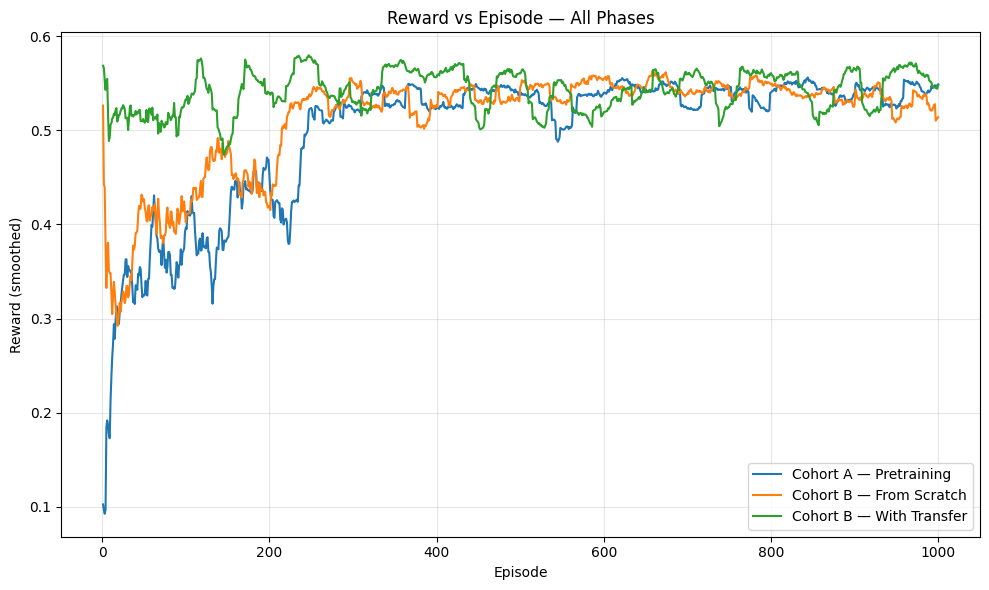

💾 Saved: /content/drive/MyDrive/dayhoff_marl_genomics/results/plots/reward_vs_episode_all_phases.png


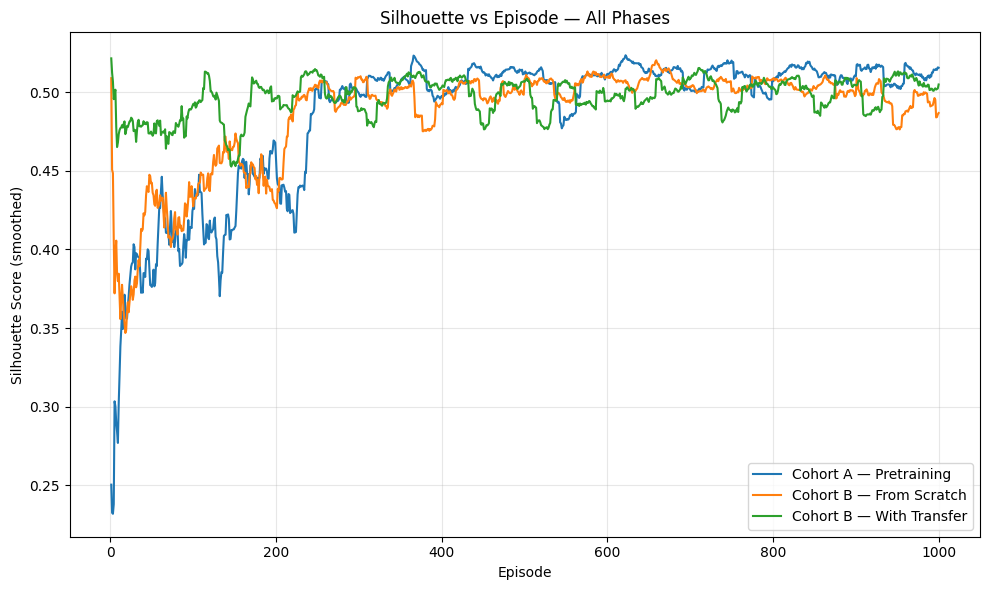

💾 Saved: /content/drive/MyDrive/dayhoff_marl_genomics/results/plots/silhouette_vs_episode_all_phases.png


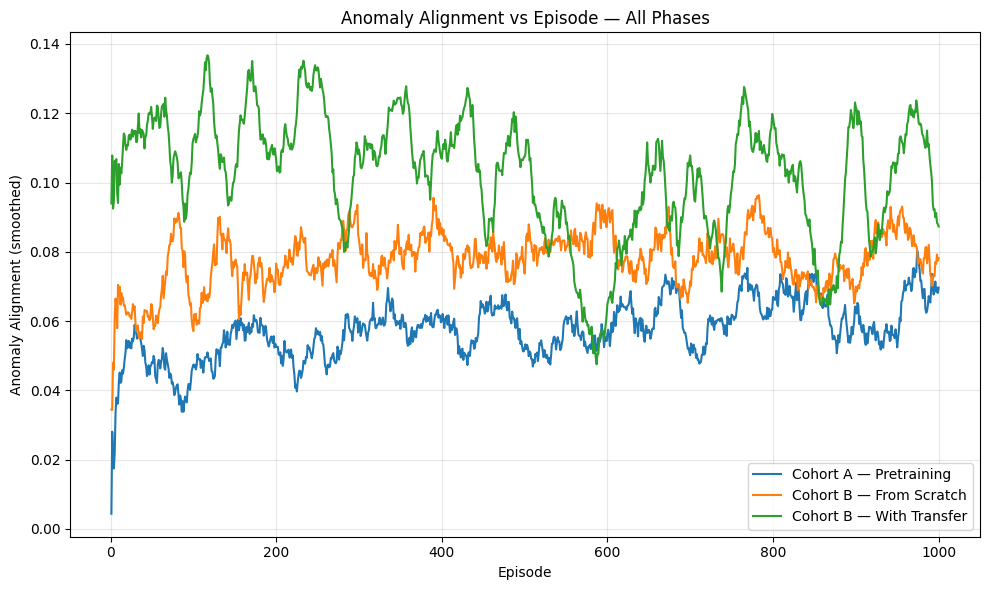

💾 Saved: /content/drive/MyDrive/dayhoff_marl_genomics/results/plots/anomaly_alignment_vs_episode_all_phases.png

===== Final 200-episode Summary (Cohort B) =====
B_scratch:
  mean_reward: 0.5319
  std_reward: 0.0679
  mean_silhouette: 0.4971
  mean_align: 0.0771
B_transfer:
  mean_reward: 0.5474
  std_reward: 0.0657
  mean_silhouette: 0.5026
  mean_align: 0.0956


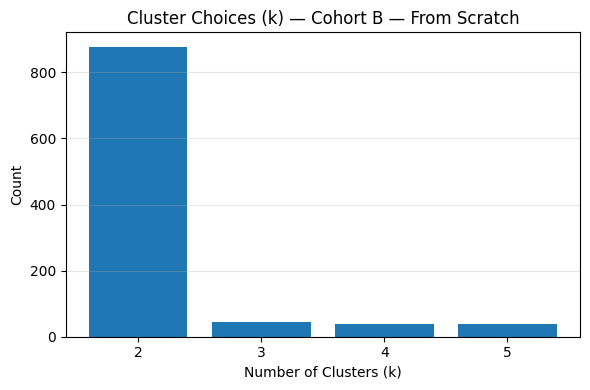

💾 Saved: /content/drive/MyDrive/dayhoff_marl_genomics/results/plots/cluster_choice_freq_B_scratch.png


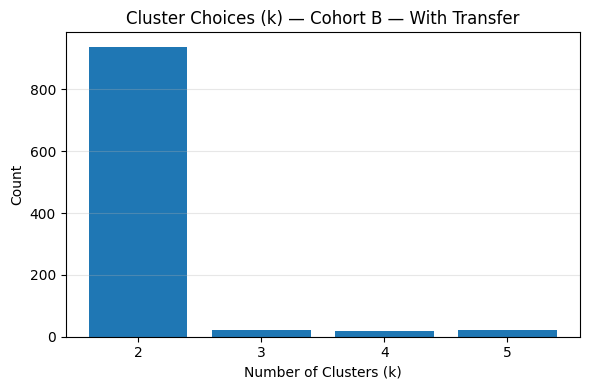

💾 Saved: /content/drive/MyDrive/dayhoff_marl_genomics/results/plots/cluster_choice_freq_B_transfer.png


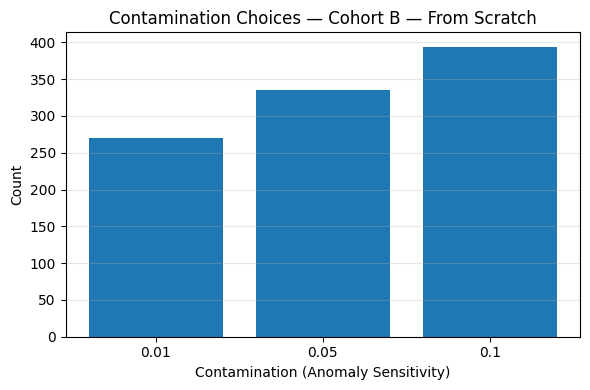

💾 Saved: /content/drive/MyDrive/dayhoff_marl_genomics/results/plots/contamination_choice_freq_B_scratch.png


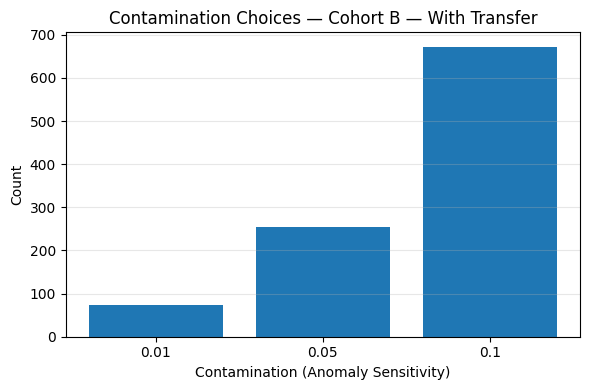

💾 Saved: /content/drive/MyDrive/dayhoff_marl_genomics/results/plots/contamination_choice_freq_B_transfer.png

✅ All plots generated and saved to: /content/drive/MyDrive/dayhoff_marl_genomics/results/plots


In [8]:
# ============================================================
# STEP 7 — Plot & Analyze MARL + Transfer Learning Results
#  - Loads latest marl_transfer_log_*.csv
#  - Creates plots for reward, silhouette, anomaly alignment
#  - Compares B_scratch vs B_transfer
#  - Saves all plots to results/plots/
# ============================================================

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = "/content/drive/MyDrive/dayhoff_marl_genomics"
RESULTS_PATH = os.path.join(PROJECT_ROOT, "results")
PLOTS_PATH = os.path.join(RESULTS_PATH, "plots")
os.makedirs(PLOTS_PATH, exist_ok=True)

# ------------------------------------------------------------
# 1. Find latest transfer log
# ------------------------------------------------------------
log_pattern = os.path.join(RESULTS_PATH, "marl_transfer_log_*.csv")
log_files = glob.glob(log_pattern)

if not log_files:
    raise FileNotFoundError(f"No files found matching {log_pattern}")

latest_log = max(log_files, key=os.path.getmtime)
print("📄 Using log file:", latest_log)

df = pd.read_csv(latest_log)
print("\nPhases present:", df["phase"].unique())
print("Total rows:", len(df))

# Sanity: check episodes per phase
print("\nEpisodes per phase:")
print(df.groupby("phase")["episode"].max())

# ------------------------------------------------------------
# Helper: rolling mean for smoother curves
# ------------------------------------------------------------
def smooth_series(s, window=25):
    return s.rolling(window=window, min_periods=1, center=False).mean()

phases = ["A_pretrain", "B_scratch", "B_transfer"]
phase_labels = {
    "A_pretrain": "Cohort A — Pretraining",
    "B_scratch": "Cohort B — From Scratch",
    "B_transfer": "Cohort B — With Transfer",
}

# ------------------------------------------------------------
# 2. Plot Reward vs Episode (all phases)
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
for ph in phases:
    ph_df = df[df["phase"] == ph].copy()
    smoothed = smooth_series(ph_df["reward"], window=25)
    plt.plot(ph_df["episode"], smoothed, label=phase_labels[ph])

plt.xlabel("Episode")
plt.ylabel("Reward (smoothed)")
plt.title("Reward vs Episode — All Phases")
plt.grid(True, alpha=0.3)
plt.legend()
reward_plot_path = os.path.join(PLOTS_PATH, "reward_vs_episode_all_phases.png")
plt.tight_layout()
plt.savefig(reward_plot_path, dpi=150)
plt.show()
print("💾 Saved:", reward_plot_path)

# ------------------------------------------------------------
# 3. Plot Silhouette vs Episode (all phases)
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
for ph in phases:
    ph_df = df[df["phase"] == ph].copy()
    smoothed = smooth_series(ph_df["silhouette"], window=25)
    plt.plot(ph_df["episode"], smoothed, label=phase_labels[ph])

plt.xlabel("Episode")
plt.ylabel("Silhouette Score (smoothed)")
plt.title("Silhouette vs Episode — All Phases")
plt.grid(True, alpha=0.3)
plt.legend()
sil_plot_path = os.path.join(PLOTS_PATH, "silhouette_vs_episode_all_phases.png")
plt.tight_layout()
plt.savefig(sil_plot_path, dpi=150)
plt.show()
print("💾 Saved:", sil_plot_path)

# ------------------------------------------------------------
# 4. Plot Anomaly Alignment vs Episode (all phases)
#     anomaly_alignment = P(malignant flagged) - P(benign flagged)
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
for ph in phases:
    ph_df = df[df["phase"] == ph].copy()
    smoothed = smooth_series(ph_df["anomaly_alignment"], window=25)
    plt.plot(ph_df["episode"], smoothed, label=phase_labels[ph])

plt.xlabel("Episode")
plt.ylabel("Anomaly Alignment (smoothed)")
plt.title("Anomaly Alignment vs Episode — All Phases")
plt.grid(True, alpha=0.3)
plt.legend()
align_plot_path = os.path.join(PLOTS_PATH, "anomaly_alignment_vs_episode_all_phases.png")
plt.tight_layout()
plt.savefig(align_plot_path, dpi=150)
plt.show()
print("💾 Saved:", align_plot_path)

# ------------------------------------------------------------
# 5. Compare final performance for B_scratch vs B_transfer
#    (last 200 episodes)
# ------------------------------------------------------------
def tail_stats(df, phase, tail=200):
    ph_df = df[df["phase"] == phase].copy()
    tail_df = ph_df.tail(tail)
    return {
        "mean_reward": tail_df["reward"].mean(),
        "std_reward": tail_df["reward"].std(),
        "mean_silhouette": tail_df["silhouette"].mean(),
        "mean_align": tail_df["anomaly_alignment"].mean(),
    }

stats_B_scratch = tail_stats(df, "B_scratch", tail=200)
stats_B_transfer = tail_stats(df, "B_transfer", tail=200)

print("\n===== Final 200-episode Summary (Cohort B) =====")
print("B_scratch:")
for k, v in stats_B_scratch.items():
    print(f"  {k}: {v:.4f}")
print("B_transfer:")
for k, v in stats_B_transfer.items():
    print(f"  {k}: {v:.4f}")

# ------------------------------------------------------------
# 6. Action frequency plots — cluster choices (k) for B_scratch vs B_transfer
# ------------------------------------------------------------
for ph in ["B_scratch", "B_transfer"]:
    ph_df = df[df["phase"] == ph].copy()
    counts = ph_df["n_clusters"].value_counts().sort_index()
    plt.figure(figsize=(6, 4))
    plt.bar(counts.index.astype(str), counts.values)
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Count")
    plt.title(f"Cluster Choices (k) — {phase_labels[ph]}")
    plt.grid(True, axis="y", alpha=0.3)
    out_path = os.path.join(PLOTS_PATH, f"cluster_choice_freq_{ph}.png")
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.show()
    print("💾 Saved:", out_path)

# ------------------------------------------------------------
# 7. Action frequency plots — contamination choices for B_scratch vs B_transfer
# ------------------------------------------------------------
for ph in ["B_scratch", "B_transfer"]:
    ph_df = df[df["phase"] == ph].copy()
    counts = ph_df["contamination"].value_counts().sort_index()
    plt.figure(figsize=(6, 4))
    plt.bar(counts.index.astype(str), counts.values)
    plt.xlabel("Contamination (Anomaly Sensitivity)")
    plt.ylabel("Count")
    plt.title(f"Contamination Choices — {phase_labels[ph]}")
    plt.grid(True, axis="y", alpha=0.3)
    out_path = os.path.join(PLOTS_PATH, f"contamination_choice_freq_{ph}.png")
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.show()
    print("💾 Saved:", out_path)

print("\n✅ All plots generated and saved to:", PLOTS_PATH)
